In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

## Helper functions

In [2]:
def diff_percent(Dm,AAA):
    return 100*((Dm-AAA)/AAA)

print(diff_percent(105.0,100.0))

5.0


In [3]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [4]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [26]:
def bland_altman_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('Dose (Gy)')
    plt.ylabel('Difference Gy')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy mean difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

In [6]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

# Start analysis

In [7]:
HN_df = pd.read_csv('HN_df_clean_28_11.csv')  # read in the cleaned data

In [8]:
HN_df['Dm-AAA'] = HN_df['Dm'] - HN_df['AAA'] # get abs diff

In [9]:
HN_df['Dm-AAA%'] = diff_percent(HN_df['Dm'], HN_df['AAA'])

In [10]:
HN_df.head()

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
0,Case1,Body,D2%,68.721677,67.963184,-0.758493,-1.103718
1,Case1,Body,D5%,64.466712,63.828810,-0.637901,-0.989505
2,Case1,Body,D50%,4.963856,4.830868,-0.132988,-2.679137
3,Case1,Body,D95%,0.456212,0.483118,0.026906,5.897773
4,Case1,Body,D99%,0.215975,0.332683,0.116709,54.038163


In [11]:
HN_sub_df = HN_df[['Case', 'structure', 'metric', 'Dm-AAA%']]
HN_sub_df.head()

,Case,structure,metric,Dm-AAA%
0,Case1,Body,D2%,-1.103718
1,Case1,Body,D5%,-0.989505
2,Case1,Body,D50%,-2.679137
3,Case1,Body,D95%,5.897773
4,Case1,Body,D99%,54.038163


Everything imported OK

## Get mean dose differences

In [12]:
mean_diff_table = HN_sub_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA%') 

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


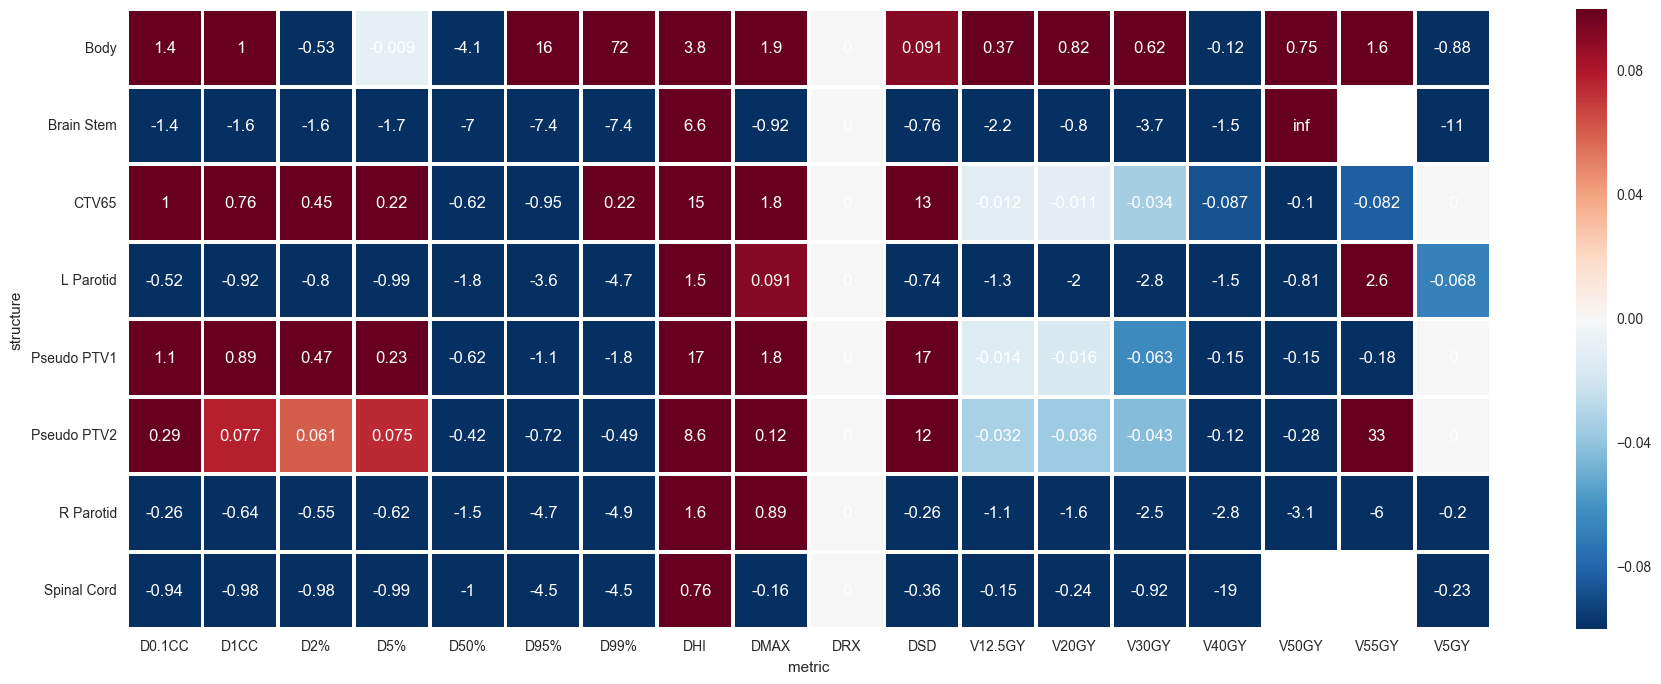

In [13]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)

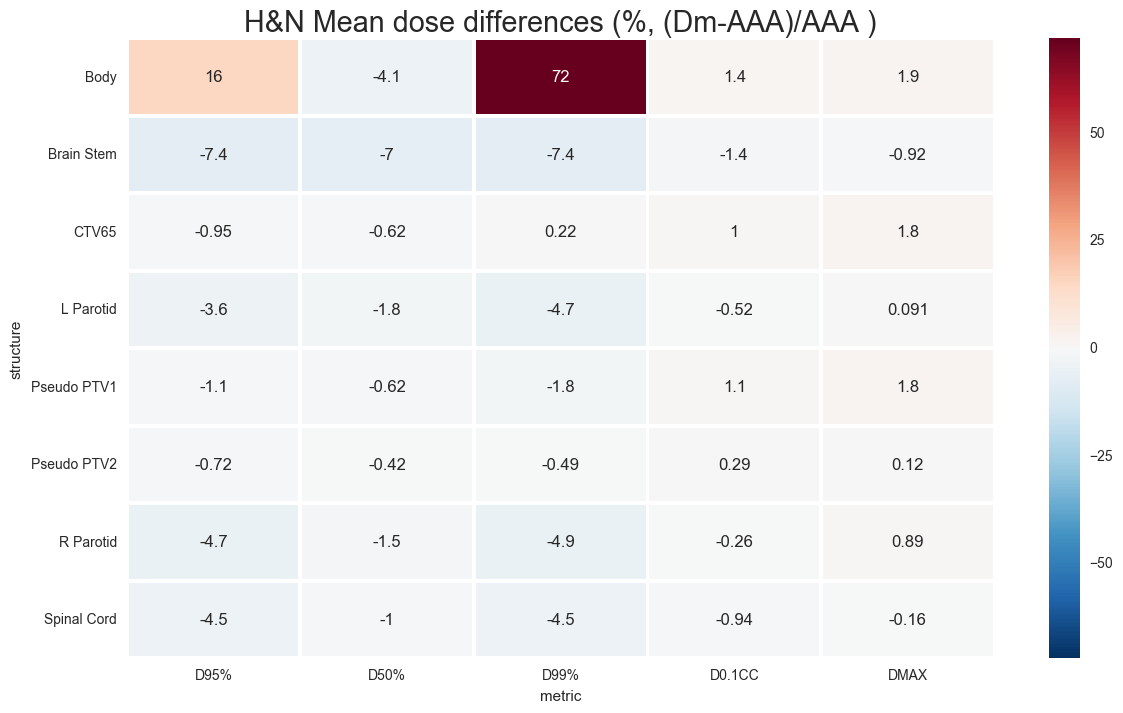

In [14]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table[metrics_of_interest], annot=True, linewidths=2.0, cbar=True)
ax1.set_title('H&N Mean dose differences (%, (Dm-AAA)/AAA )', size='xx-large')
plt.savefig('H&N Mean dose difference.png', dpi=200)

## Get wilcoxon p value of differences

In [15]:
structures_of_interest = HN_sub_df['structure'].unique()

In [16]:
structures_of_interest

array(['Body', 'R Parotid', 'L Parotid', 'Brain Stem', 'Spinal Cord',
       'CTV65', 'Pseudo PTV1', 'Pseudo PTV2'], dtype=object)

In [17]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [18]:
d = HN_df  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA%']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

In [19]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [20]:
wilcox_data_df

,D95%,D50%,D99%,D0.1CC,DMAX
Body,0.021824,0.021824,0.006910,0.006910,0.028417
R Parotid,0.012515,0.016605,0.012515,0.114128,0.646462
L Parotid,0.016605,0.005062,0.006910,0.092601,0.386271
Brain Stem,0.006910,0.005062,0.006910,0.059336,0.139414
Spinal Cord,0.028417,0.021824,0.016605,0.074462,0.646462
CTV65,0.092601,0.074462,0.646462,0.036658,0.016605
Pseudo PTV1,0.074462,0.074462,0.046853,0.009344,0.028417
Pseudo PTV2,0.114128,0.074462,0.241121,0.721277,0.646462


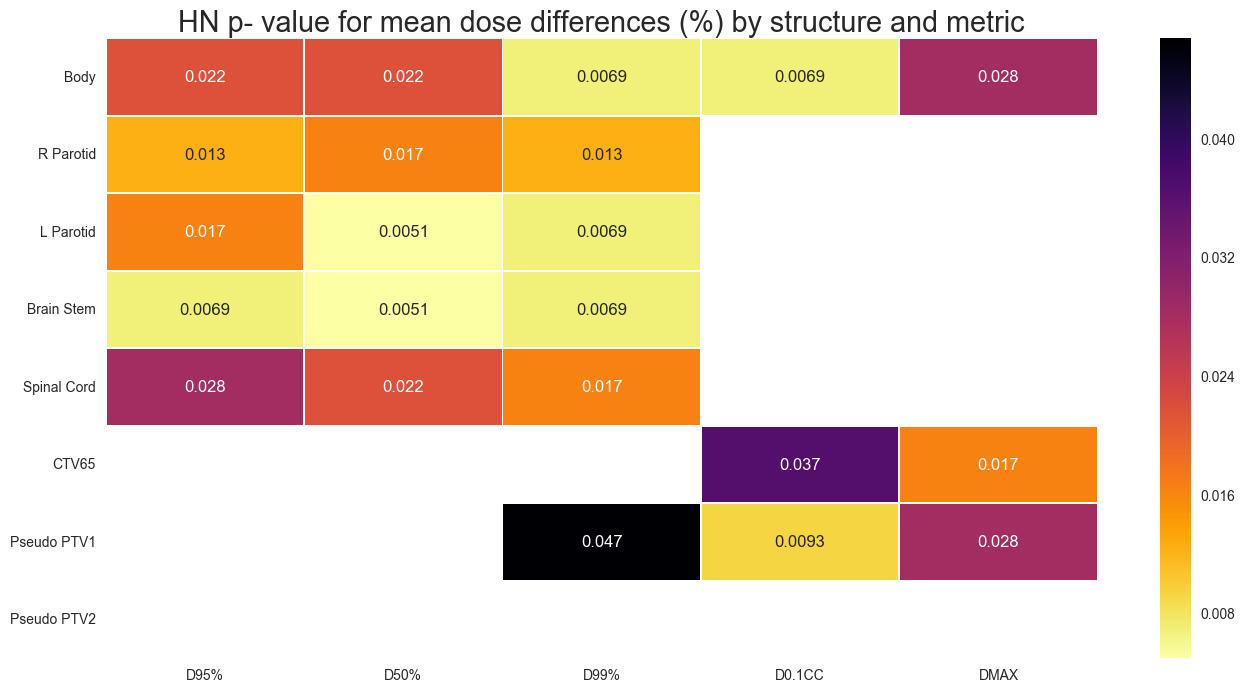

In [21]:
confidence = 0.05
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
ax2.set_title('HN p- value for mean dose differences (%) by structure and metric', size='xx-large')
plt.savefig('HN p value for mean dose differences.png', dpi=500)

In [22]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

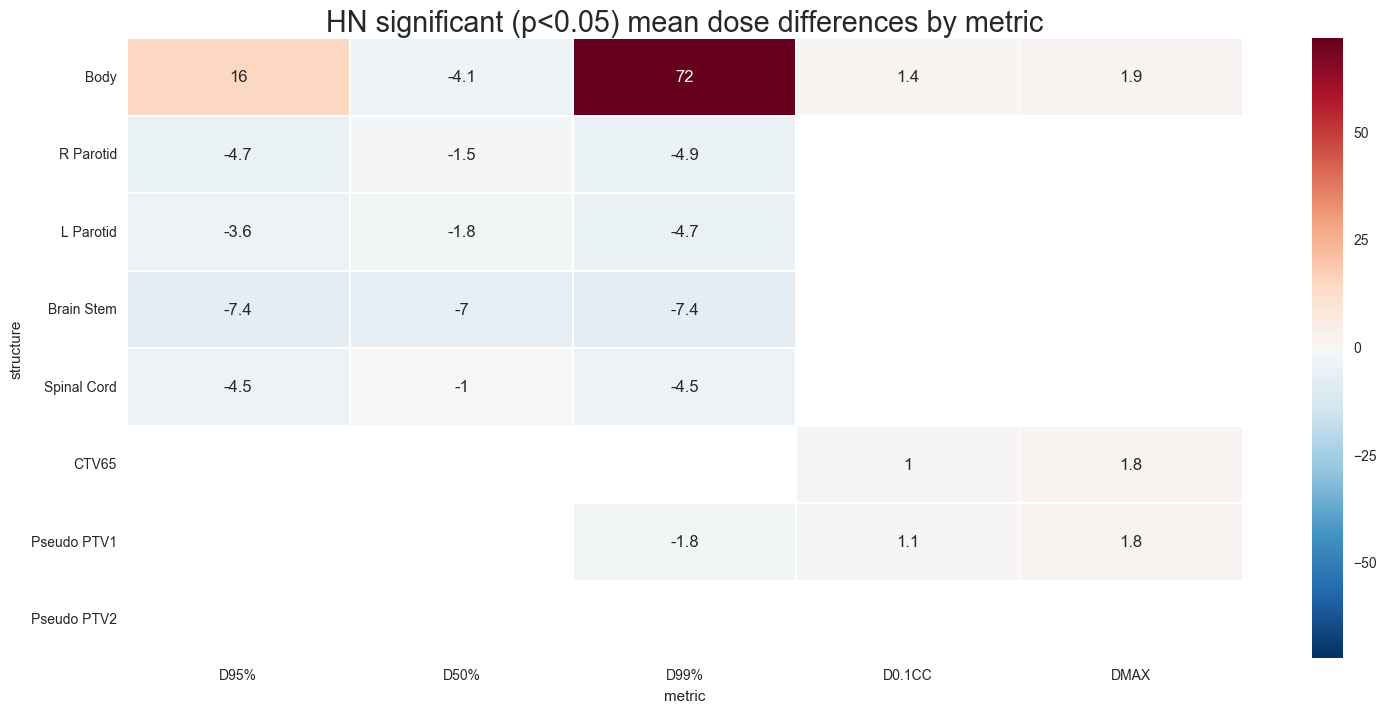

In [23]:
plt.figure(figsize=(18, 8)) 
data = sub_diff_table[wilcox_data_df<0.05]
mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('HN significant (p<0.05) mean dose differences by metric', size='xx-large')
plt.savefig('HN significant mean dose differences by metric.png', dpi=500)

# Investigate differences 
### CTV65 D0.1CC

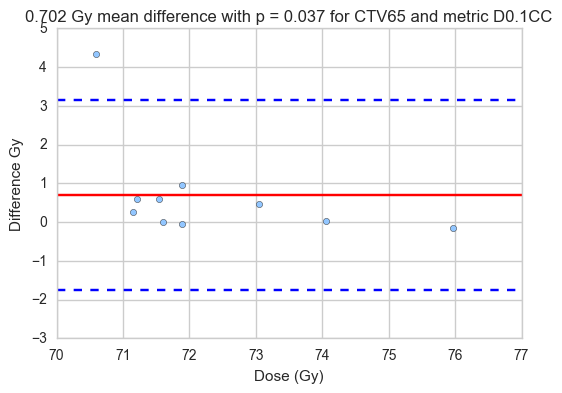

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
96,Case1,CTV65,D0.1CC,71.595076,71.608581,0.013505,0.018863
276,Case2,CTV65,D0.1CC,74.046682,74.071124,0.024442,0.033009
420,Case3,CTV65,D0.1CC,72.804075,73.278284,0.474209,0.651350
528,Case4,CTV65,D0.1CC,71.251420,71.835154,0.583734,0.819260
672,Case5,CTV65,D0.1CC,76.038942,75.888119,-0.150823,-0.198349
744,Case6,CTV65,D0.1CC,71.414223,72.364125,0.949902,1.330130
870,Case7,CTV65,D0.1CC,68.418821,72.754965,4.336144,6.337648
1122,Case8,CTV65,D0.1CC,71.914920,71.873210,-0.041710,-0.057999
1158,Case9,CTV65,D0.1CC,70.916552,71.501134,0.584582,0.824324
1302,Case10,CTV65,D0.1CC,71.019774,71.269783,0.250010,0.352028


In [27]:
structure = 'CTV65'
metric = 'D0.1CC'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]

### Pseudo PTV1 DMAX

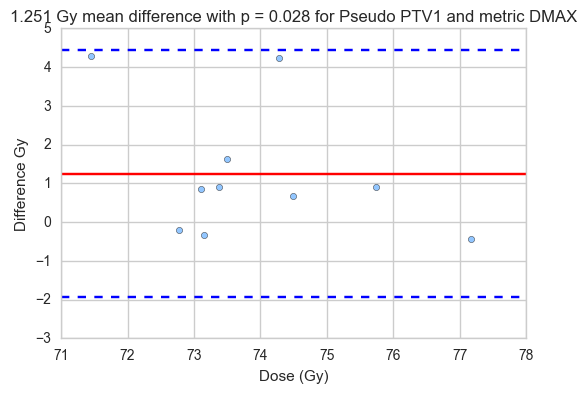

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
115,Case1,Pseudo PTV1,DMAX,73.32000,72.99500,-0.32500,-0.443262
151,Case2,Pseudo PTV1,DMAX,75.28158,76.19172,0.91014,1.208981
295,Case3,Pseudo PTV1,DMAX,74.16500,74.83000,0.66500,0.896649
565,Case4,Pseudo PTV1,DMAX,72.92000,73.83500,0.91500,1.254800
583,Case5,Pseudo PTV1,DMAX,77.39100,76.94400,-0.44700,-0.577587
835,Case6,Pseudo PTV1,DMAX,72.16110,76.38675,4.22565,5.855856
979,Case7,Pseudo PTV1,DMAX,69.30066,73.59132,4.29066,6.191370
1141,Case8,Pseudo PTV1,DMAX,72.68118,73.52631,0.84513,1.162791
1267,Case9,Pseudo PTV1,DMAX,72.68118,74.30643,1.62525,2.236136
1411,Case10,Pseudo PTV1,DMAX,72.87621,72.68118,-0.19503,-0.267618


In [29]:
structure = 'Pseudo PTV1'
metric = 'DMAX'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]

### Brain stem D50%

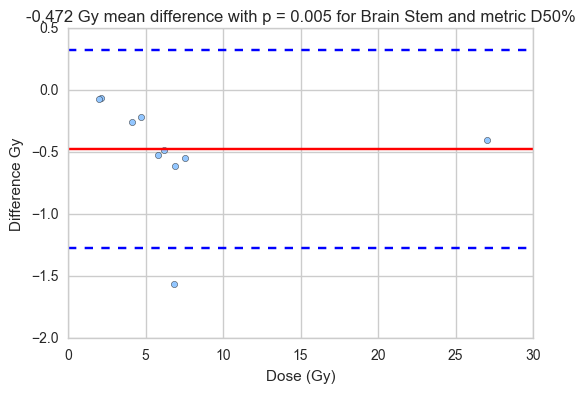

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
56,Case1,Brain Stem,D50%,27.252817,26.854172,-0.398645,-1.462765
236,Case2,Brain Stem,D50%,2.143964,2.082395,-0.061569,-2.871744
380,Case3,Brain Stem,D50%,4.236256,3.983629,-0.252627,-5.963459
470,Case4,Brain Stem,D50%,6.073990,5.556459,-0.517532,-8.520461
686,Case5,Brain Stem,D50%,2.046338,1.974176,-0.072162,-3.526414
794,Case6,Brain Stem,D50%,4.792651,4.578888,-0.213763,-4.460219
920,Case7,Brain Stem,D50%,7.637237,6.071817,-1.565420,-20.497204
1046,Case8,Brain Stem,D50%,6.425576,5.942164,-0.483412,-7.523243
1172,Case9,Brain Stem,D50%,7.804884,7.261682,-0.543202,-6.959772
1370,Case10,Brain Stem,D50%,7.165912,6.556099,-0.609812,-8.509905


In [28]:
structure = 'Brain Stem'
metric = 'D50%'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]